## Homework

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

--2022-05-11 21:13:21--  https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX
Resolving docs.google.com (docs.google.com)... 142.251.1.194, 2a00:1450:4010:c1e::c2
Connecting to docs.google.com (docs.google.com)|142.251.1.194|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lulbf3mbf4s26a4pj119ck9p5dfbcc7l/1652292750000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download [following]
--2022-05-11 21:13:22--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lulbf3mbf4s26a4pj119ck9p5dfbcc7l/1652292750000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 64.233.161.132, 2a00:1450:4010:c01::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.c

In [2]:
import warnings
warnings.filterwarnings('ignore')

В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

### Setup

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("data.csv", parse_dates=["timestamp"])

Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

In [5]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(df, test_size=0.2, random_state=42)

Возможно в ваших моделях вам придется указывать, какие колонки являются категориальными (например, в бустингах). Для упрощения предлагается разделить колонки по следующему принципу:

In [6]:
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))

target = 'price'

In [7]:
X_train = train[cat_columns + num_columns]
y_train = train[target]

X_test = test[cat_columns + num_columns]
y_test = test[target]

Среди категориальных признаков есть те, которые имеют строковый тип. В таком виде данные использовать не получится, поэтому закодируем их с помощью OneHotEncoder:

In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

### Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

In [9]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=2, random_state=42).fit(X_train, y_train)

Проверьте качество на отложенной выборке.

In [10]:
from sklearn.metrics import mean_squared_error

y_preds = reg.predict(X_test)

mean_squared_error(y_test, y_preds, squared=False)

4075756.2236529705

### Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлились объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [11]:
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df["week_year_cnt"] = week_year.map(week_year_cnt_map)

Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitchen_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

In [12]:
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday

df['floor_to_max_floor'] = df['floor'] / df['max_floor']
df['kitchen_square_frac'] = df['kitch_sq'] / df['full_sq']

Попробуем добавить признак, содержащий данные об отношении доли зеленых зон к доле промышленных зон:

In [13]:
df['green_frac'] = df['green_part_500'] / df['prom_part_500']

Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [14]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = train[cat_columns + num_columns]
y_train = train[target]

X_test = test[cat_columns + num_columns]
y_test = test[target]

In [15]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

### Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

In [16]:
tree = DecisionTreeRegressor(max_depth=2, random_state=42).fit(X_train, y_train)

tree_preds = tree.predict(X_test)

In [17]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=42).fit(X_train, y_train)

forest_preds = forest.predict(X_test)

In [18]:
from catboost import CatBoostRegressor, Pool

train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_test, y_test)

cb = CatBoostRegressor(loss_function='RMSE', iterations=2, depth=2)
cb.fit(train_dataset)

cb_preds = cb.predict(test_dataset)

Learning rate set to 0.5
0:	learn: 4397023.9608107	total: 239ms	remaining: 239ms
1:	learn: 4216659.9214687	total: 391ms	remaining: 0us


In [19]:
print('DecisionTreeRegressor:', mean_squared_error(y_test, tree_preds, squared=False))
print('RandomForestRegressor:', mean_squared_error(y_test, forest_preds, squared=False))
print('CatBoostRegressor:', mean_squared_error(y_test, cb_preds, squared=False))

DecisionTreeRegressor: 4075756.2236529705
RandomForestRegressor: 4067791.259494771
CatBoostRegressor: 4000875.9672940834


С параметрами по умолчанию CatBoost показывает лучшие результаты. Попробуем подобрать оптимальные гиперпараметры для всех моделей:

In [20]:
from sklearn.model_selection import GridSearchCV

reg = DecisionTreeRegressor(random_state=42)

params = {
          'max_depth': np.arange(2, 5), 
          'min_samples_leaf': np.arange(10, 20, 2),
          'min_samples_split': np.arange(10, 50, 10)
         }

tree = GridSearchCV(reg, params, n_jobs=-1)
tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4]),
                         'min_samples_leaf': array([10, 12, 14, 16, 18]),
                         'min_samples_split': array([10, 20, 30, 40])})

In [21]:
tree_preds = tree.predict(X_test)
print('DecisionTreeRegressor:', mean_squared_error(y_test, tree_preds, squared=False))

DecisionTreeRegressor: 3869262.753494675


In [22]:
reg = RandomForestRegressor(random_state=42, max_features='log2', n_estimators=50)

params = {
          'max_depth': np.arange(2, 5), 
          'min_samples_leaf': np.arange(10, 20, 2),
          'min_samples_split': np.arange(10, 50, 10)
         }

forest = GridSearchCV(reg, params)
forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(max_features='log2',
                                             n_estimators=50, random_state=42),
             param_grid={'max_depth': array([2, 3, 4]),
                         'min_samples_leaf': array([10, 12, 14, 16, 18]),
                         'min_samples_split': array([10, 20, 30, 40])})

In [23]:
forest_preds = forest.predict(X_test)
print('DecisionTreeRegressor:', mean_squared_error(y_test, forest_preds, squared=False))

DecisionTreeRegressor: 4455207.710311234


In [24]:
cb = CatBoostRegressor(loss_function='RMSE')

params = {
          'depth': np.arange(2, 5), 
          'iterations': np.arange(2, 5), 
          'learning_rate': np.logspace(-2, 0, 10)
         }

res = cb.grid_search(params, train_dataset)

0:	learn: 8505770.9055024	test: 8332932.6820071	best: 8332932.6820071 (0)	total: 104ms	remaining: 104ms
1:	learn: 8447487.9631436	test: 8273696.4862661	best: 8273696.4862661 (1)	total: 279ms	remaining: 0us

bestTest = 8273696.486
bestIteration = 1

0:	loss: 8273696.4862661	best: 8273696.4862661 (0)	total: 14s	remaining: 20m 45s
0:	learn: 8466404.8406850	test: 8292929.9416744	best: 8292929.9416744 (0)	total: 101ms	remaining: 101ms
1:	learn: 8370149.8681160	test: 8195079.7284963	best: 8195079.7284963 (1)	total: 297ms	remaining: 0us

bestTest = 8195079.728
bestIteration = 1

1:	loss: 8195079.7284963	best: 8195079.7284963 (1)	total: 14.6s	remaining: 10m 42s
0:	learn: 8400926.8630426	test: 8226380.2566372	best: 8226380.2566372 (0)	total: 78.7ms	remaining: 78.7ms
1:	learn: 8242457.2287865	test: 8065626.1622131	best: 8065626.1622131 (1)	total: 238ms	remaining: 0us

bestTest = 8065626.162
bestIteration = 1

2:	loss: 8065626.1622131	best: 8065626.1622131 (2)	total: 15.1s	remaining: 7m 18s
0:	le

0:	learn: 8466404.8406850	test: 8292929.9416744	best: 8292929.9416744 (0)	total: 76.2ms	remaining: 229ms
1:	learn: 8370149.8681160	test: 8195079.7284963	best: 8195079.7284963 (1)	total: 231ms	remaining: 231ms
2:	learn: 8275980.4386651	test: 8099329.2766162	best: 8099329.2766162 (2)	total: 310ms	remaining: 103ms
3:	learn: 8183903.6904288	test: 8005662.7795672	best: 8005662.7795672 (3)	total: 466ms	remaining: 0us

bestTest = 8005662.78
bestIteration = 3

21:	loss: 8005662.7795672	best: 3997140.6227217 (19)	total: 27.6s	remaining: 1m 25s
0:	learn: 8400926.8630426	test: 8226380.2566372	best: 8226380.2566372 (0)	total: 76.3ms	remaining: 229ms
1:	learn: 8242457.2287865	test: 8065626.1622131	best: 8065626.1622131 (1)	total: 231ms	remaining: 231ms
2:	learn: 8090349.4749491	test: 7910875.0467192	best: 7910875.0467192 (2)	total: 311ms	remaining: 104ms
3:	learn: 7937284.5733432	test: 7755802.2982270	best: 7755802.2982270 (3)	total: 467ms	remaining: 0us

bestTest = 7755802.298
bestIteration = 3

2

0:	learn: 8505770.9055024	test: 8332932.6820071	best: 8332932.6820071 (0)	total: 77.8ms	remaining: 156ms
1:	learn: 8447493.0699620	test: 8273697.6756413	best: 8273697.6756413 (1)	total: 344ms	remaining: 172ms
2:	learn: 8387915.0649257	test: 8213090.5158234	best: 8213090.5158234 (2)	total: 588ms	remaining: 0us

bestTest = 8213090.516
bestIteration = 2

40:	loss: 8213090.5158234	best: 3742572.2550752 (29)	total: 40.6s	remaining: 48.5s
0:	learn: 8466404.8406850	test: 8292929.9416744	best: 8292929.9416744 (0)	total: 90.2ms	remaining: 180ms
1:	learn: 8370158.3318638	test: 8195081.7044558	best: 8195081.7044558 (1)	total: 334ms	remaining: 167ms
2:	learn: 8272546.2766974	test: 8095744.2157691	best: 8095744.2157691 (2)	total: 581ms	remaining: 0us

bestTest = 8095744.216
bestIteration = 2

41:	loss: 8095744.2157691	best: 3742572.2550752 (29)	total: 41.4s	remaining: 47.3s
0:	learn: 8400926.8630426	test: 8226380.2566372	best: 8226380.2566372 (0)	total: 82.2ms	remaining: 164ms
1:	learn: 8242471.164

1:	learn: 5482905.4698139	test: 5256292.8836392	best: 5256292.8836392 (1)	total: 322ms	remaining: 322ms
2:	learn: 4836206.1565092	test: 4602756.9243343	best: 4602756.9243343 (2)	total: 565ms	remaining: 188ms
3:	learn: 4449933.2253150	test: 4216833.0424139	best: 4216833.0424139 (3)	total: 809ms	remaining: 0us

bestTest = 4216833.042
bestIteration = 3

57:	loss: 4216833.0424139	best: 3742572.2550752 (29)	total: 56.5s	remaining: 31.2s
0:	learn: 5550118.4908339	test: 5306821.2119071	best: 5306821.2119071 (0)	total: 77.2ms	remaining: 232ms
1:	learn: 4469132.0435713	test: 4232336.5100631	best: 4232336.5100631 (1)	total: 329ms	remaining: 329ms
2:	learn: 4122771.8554317	test: 3865048.8724616	best: 3865048.8724616 (2)	total: 575ms	remaining: 192ms
3:	learn: 3917231.7631820	test: 3693584.7010620	best: 3693584.7010620 (3)	total: 823ms	remaining: 0us

bestTest = 3693584.701
bestIteration = 3

58:	loss: 3693584.7010620	best: 3693584.7010620 (58)	total: 57.5s	remaining: 30.2s
0:	learn: 4760967.84442

0:	learn: 5550118.4908339	test: 5306821.2119071	best: 5306821.2119071 (0)	total: 76.6ms	remaining: 153ms
1:	learn: 4469138.4314265	test: 4232323.5181502	best: 4232323.5181502 (1)	total: 415ms	remaining: 208ms
2:	learn: 4061764.7857855	test: 3832128.3145223	best: 3832128.3145223 (2)	total: 764ms	remaining: 0us

bestTest = 3832128.315
bestIteration = 2

78:	loss: 3832128.3145223	best: 3693584.7010620 (58)	total: 1m 14s	remaining: 10.4s
0:	learn: 4760967.8444292	test: 4495337.1418507	best: 4495337.1418507 (0)	total: 76.7ms	remaining: 153ms
1:	learn: 4102170.0089486	test: 3969546.7845359	best: 3969546.7845359 (1)	total: 416ms	remaining: 208ms
2:	learn: 3790206.5742623	test: 3682646.6894721	best: 3682646.6894721 (2)	total: 759ms	remaining: 0us

bestTest = 3682646.689
bestIteration = 2

79:	loss: 3682646.6894721	best: 3682646.6894721 (79)	total: 1m 15s	remaining: 9.5s
0:	learn: 8505770.9055024	test: 8332932.6820071	best: 8332932.6820071 (0)	total: 76.8ms	remaining: 230ms
1:	learn: 8447495.37

Посмотрим на оптимальные параметры для CatBoostRegressor:

In [25]:
print(res['params'])

{'depth': 4, 'iterations': 4, 'learning_rate': 0.5994842503189409}


In [26]:
cb_preds = cb_preds = cb.predict(test_dataset)

In [27]:
print('CatBoostRegressor:', mean_squared_error(y_test, cb_preds, squared=False))

CatBoostRegressor: 3553820.435219051


### Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

In [28]:
invest_train = train[train['product_type'] == 'Investment']
invest_train_X = invest_train[cat_columns + num_columns]
invest_train_y = invest_train[target]

owner_train = train[train['product_type'] == 'OwnerOccupier']
owner_train_X = owner_train[cat_columns + num_columns]
owner_train_y = owner_train[target]

In [29]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
invest_train_X = encoder.fit_transform(invest_train_X)

owner_train_X = encoder.transform(owner_train_X)

X_test = test[cat_columns + num_columns]
y_test = test[target]

X_test = encoder.transform(X_test)
test_dataset = Pool(X_test, y_test)

In [30]:
model_invest = CatBoostRegressor(loss_function='RMSE', depth=4, iterations=3, learning_rate=1.0)

train_dataset = Pool(invest_train_X, invest_train_y)
model_invest.fit(train_dataset)

0:	learn: 4254758.3305879	total: 362ms	remaining: 724ms
1:	learn: 3912247.3839573	total: 702ms	remaining: 351ms
2:	learn: 3842649.7392023	total: 1.03s	remaining: 0us


In [31]:
model_owner = CatBoostRegressor(loss_function='RMSE', depth=4, iterations=3, learning_rate=1.0)

train_dataset = Pool(owner_train_X, owner_train_y) 
model_owner.fit(train_dataset)

0:	learn: 3426487.1846663	total: 20ms	remaining: 39.9ms
1:	learn: 3010383.2869558	total: 40.3ms	remaining: 20.2ms
2:	learn: 2679488.5117955	total: 61.9ms	remaining: 0us


In [41]:
invest_preds = model_invest.predict(test_dataset)
owner_preds = model_owner.predict(test_dataset)

preds = np.mean(np.array([invest_preds, owner_preds]), axis=0)

In [42]:
print('Invest:', mean_squared_error(y_test, invest_preds, squared=False))
print('Owner:', mean_squared_error(y_test, owner_preds, squared=False))

Invest: 3839614.597130152
Owner: 5634685.0009084465


In [43]:
print('Ensemble:', mean_squared_error(y_test, preds, squared=False))

Ensemble: 4102707.6930652736


В нашем случае ансамбль показал себя хуже, чем обычная модель

### (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

In [44]:
from sklearn.linear_model import HuberRegressor

hub = HuberRegressor().fit(invest_train_X, invest_train_y)

hub_preds = hub.predict(X_test)

In [45]:
res = np.array([])
weights = np.arange(0, 1.1, 0.1)

for weight in weights:
    preds = weight * invest_preds + (1 - weight) * hub_preds
    
    res = np.append(res, mean_squared_error(y_test, preds, squared=False))

Text(0, 0.5, 'Значение RMSE')

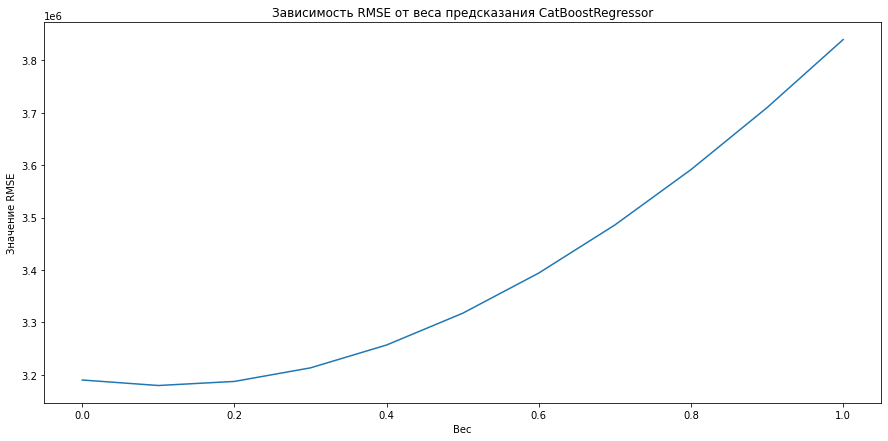

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(weights, res)
plt.title('Зависимость RMSE от веса предсказания CatBoostRegressor')
plt.xlabel('Вес')
plt.ylabel('Значение RMSE')

In [47]:
weight = weights[res.argmin()]

In [48]:
preds = np.mean(np.array([weight * invest_preds + (1 - weight) * hub_preds, owner_preds]), axis=0)
print('Ensemble:', mean_squared_error(y_test, preds, squared=False))

Ensemble: 3929351.3434320525


Получили чуть лучший результат, но ансамбль со взвешенными предсказаниями все равно уступает в качестве CatBoostRegressor

Заметим, что модели, обучаемые только на Investment, дают еще более точные предсказания:

In [49]:
print('Ensemble:', mean_squared_error(y_test, weight * invest_preds + (1 - weight) * hub_preds, squared=False))

Ensemble: 3179377.29679904
